# 对公寓受欢迎程度分类

Rental Listing Inquiries数据集是Kaggle平台上的一个分类竞赛任务，根据公寓的特征来预测其受欢迎程度（用户感兴趣程度分为高、中、低三类）。其中房屋的特征x共有14维，响应值y为用户对该公寓的感兴趣程度。用xgboost模型对公寓的受欢迎程度进行分类预测，用logloss作为评价标准。       
数据集来源：https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries 。

# 1.  读取数据和分析数据

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取数据 

dtrain = pd.read_csv('RentListingInquries_FE_train.csv')
dtest = pd.read_csv('RentListingInquries_FE_test.csv')

In [5]:
# 查看具体的数据

dtrain.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [6]:
dtest.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,virtual,walk,walls,war,washer,water,wheelchair,wifi,windows,work
0,1.0,1,2950,1475.000000,1475.000000,0.0,2.0,2016,6,11,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2850,1425.000000,950.000000,-1.0,3.0,2016,6,24,...,0,0,0,1,0,0,0,0,0,0
2,1.0,1,3758,1879.000000,1879.000000,0.0,2.0,2016,6,3,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2,3300,1650.000000,1100.000000,-1.0,3.0,2016,6,11,...,0,0,0,0,0,0,1,0,0,0
4,2.0,2,4900,1633.333333,1633.333333,0.0,4.0,2016,4,12,...,0,0,0,1,0,0,0,0,0,0


In [7]:
# 检查数据集中是否有缺失值

print('训练集中是否有空缺值：',dtrain.isnull().any().any())
print('测试集中是否有空缺值：',dtest.isnull().any().any())

训练集中是否有空缺值： False
测试集中是否有空缺值： True


In [8]:
# 测试集中有缺失值，把缺失值补为0

dtest =  dtest.fillna(0)
dtest.isnull().any().any()

False

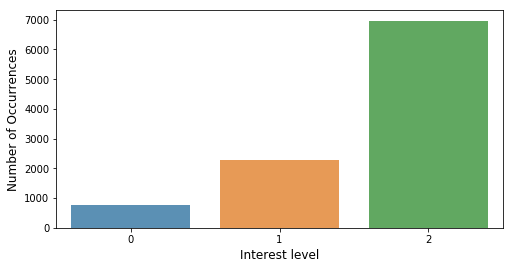

In [9]:
# 查看训练集中的类别标签 interest_level 

count_level = dtrain['interest_level'].value_counts() 

plt.figure(figsize=(8,4))
sns.barplot(count_level.index,count_level.values,alpha=0.8)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Interest level',fontsize=12)
plt.show()

# 有三个类别特征，分布不均衡。类别标签2的分布最大。

In [10]:
# 把训练集数据分割为输入特征和类别标签

y_train = dtrain['interest_level']
X_train = dtrain.drop('interest_level',axis=1)

# 测试集数据没有类别标签
X_test = dtest

# 决策树、xgboost主要处理特征的分布和特征之间的条件概率，不需要对输入特征做归一化处理，因此后面直接用原始数据进行分类

--------------------------------------------------------------------------------
# 2.  用默认的xgboost进行分类 (default xgboost)

In [11]:
from xgboost import XGBClassifier

model_XGB = XGBClassifier()
model_XGB.fit(X_train,y_train)

# 用类别标签中概率最大的类别标签2，对训练集检验分类准确率 (测试集没有类别标签，无法检验)
y_prob = model_XGB.predict_proba(X_train)[:,2]                                               
y_pred = np.where(y_prob > 0.5, 1, 0)       

# 把训练集的类别标签转化为二分类，方便与预测值比较
y_train_2 = np.zeros((len(y_train),1))
for i in range(len(y_train)):
    if y_train[i] != 2:
        y_train_2[i] = 0
    else:
        y_train_2[i] = 1
        
print('AUC of default xgboost: ',roc_auc_score(y_train_2,y_pred))

AUC of default xgboost:  0.6890133605692628


In [12]:
# 查看特征重要性

columns = X_train.columns
df = pd.DataFrame({"columns":list(columns), "importance":list(model_XGB.feature_importances_.T)})
print('重要性不为0的特征个数：', (df['importance']!=0).sum())

df.sort_values(by=['importance'],ascending=False)[:20]

# 有71个特征的重要性不为0

重要性不为0的特征个数： 71


,columns,importance
4,price_bedrooms,0.148204
2,price,0.124251
12,hour,0.080838
23,distance,0.076846
3,price_bathrooms,0.073852
22,cenroid,0.064371
96,fee,0.047904
26,display_address_pred_2,0.038423
9,Day,0.027944
11,Yday,0.023952


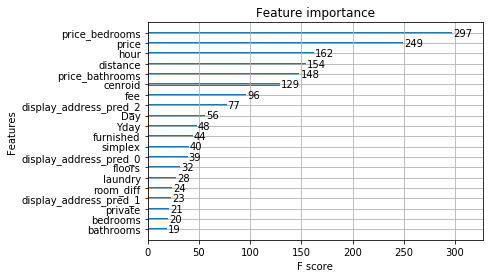

In [13]:
# 画出最重要的20个特征

from xgboost import plot_importance
plot_importance(model_XGB,max_num_features=20) 
plt.show()

In [14]:
# 根据特征重要性进行特征选择

from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel

thresholds = np.sort(model_XGB.feature_importances_)[-80:] # 227个特征中，只有71个特征的重要性不为0。为了减少运行时间，计算后面80个数。 
for thresh in thresholds:
    selection = SelectFromModel(model_XGB,threshold=thresh,prefit=True) 
    select_X_train = selection.transform(X_train)
    
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train,y_train)
    
    y_pred = selection_model.predict(select_X_train)
    
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_train,predictions)
    print('Thresh=%.3f,n=%d,accuracy: %.2f%%'%(thresh,select_X_train.shape[1],accuracy*100.0))


Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=227,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.000,n=71,accuracy: 73.70%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=62,accuracy: 73.61%
Thresh=0.001,n=53,accuracy: 73.64%
Thresh=0.00

In [15]:
# 用最佳阈值训练模型

thresh = 0.020   # 从上面数据中选择
selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)

selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

小结：   
1) 用默认的xgboost对训练数据进行分类，用predict_proba()进行预测，把训练集的类别标签转化为二分类，得到的roc_auc_score=0.6890。    
2) 用xgb.feature_importances_查看特征重要性，得到在227个输入特征中，只有71个输入特征的重要性不为0。因此大部分的输入特征对分类结果不起作用。


--------------------------------------------------------------------------------------------
# 3.  直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [16]:
# 上面特征重要性结果表明，在227个输入特征中，只有71个输入特征的重要性不为0，大部分的输入特征对分类结果不起作用。
# 因此为了提高程序运行速度，只选取重要性不为0的61个输入特进行分类参数调优。

Xcolumns = df[(df['importance']!=0)]['columns'].values
X_train = X_train[Xcolumns]
X_train.shape

(10000, 71)

In [17]:
# 交叉验证

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [18]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证

def modelfit (alg, X_train, y_train, cv_folds=kfold, early_stopping_rounds=20):    # alg = xgb1
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    xgtrain = xgb.DMatrix(X_train, label = y_train)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                      folds =cv_folds, metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
    
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    n_estimators = cvresult.shape[0]              # 最佳参数n_estimators
    alg.set_params(n_estimators = n_estimators)   #用交叉验证得到的最佳参数n_estimators训练模型
    alg.fit(X_train, y_train, eval_metric='mlogloss')
    
    # 预测训练集的logloss
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)
    
    print('best n_estimators :',n_estimators)
    print('min logloss of train :',logloss)


In [19]:
# 设置xgb的初始参数，调用上面函数求最佳的n_estimators

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,   
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds = kfold) 


best n_estimators : 122
min logloss of train : 0.4814710312674753


最小的test-mlogloss-mean : 0.6236740000000001
最小的train-mlogloss-mean : 0.448496


Text(0,0.5,'Log Loss')

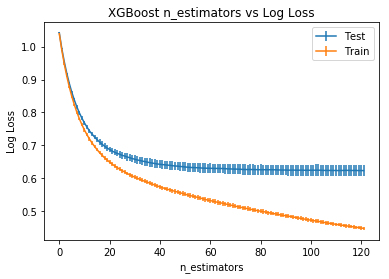

In [20]:
# 画图 n_estimators与Log Loss的关系

cvresult = pd.read_csv('1_nestimators.csv')  

print('最小的test-mlogloss-mean :',cvresult['test-mlogloss-mean'].values[-1])  
print('最小的train-mlogloss-mean :',cvresult['train-mlogloss-mean'].values[-1])  

test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])

plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.legend()
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )


小结：  
1) 直接调用xgboost内嵌的cv找到的最佳的参数n_estimators=122。      
2) 最小交叉验证测试误差：0.6237，训练误差: 0.4485。两者差异较大。

--------------------------------------------------------------------------------------------
# 4.  调整树的参数：max_depth & min_child_weight

In [21]:
# 设置max_depth和min_child_weight的范围 

max_depth = [i for i in range(3,10,2)]
min_child_weight = [i for i in range(1,6,2)]

param_test2_1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)
param_test2_1


{'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]}

In [22]:
# 设置xgb的参数，n_estimators为第一轮参数调整得到的最优值 

xgb2_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=122,                 # 第一轮参数调整得到的n_estimators最优值
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3) 

gsearch2_1 = GridSearchCV(xgb2_1, param_grid = param_test2_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch2_1.fit(X_train , y_train)

gsearch2_1.grid_scores_,    gsearch2_1.best_params_,  gsearch2_1.best_score_

([mean: -0.62666, std: 0.00295, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.62705, std: 0.00264, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.62816, std: 0.00350, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.62675, std: 0.00658, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.62658, std: 0.00546, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.62685, std: 0.00356, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.63793, std: 0.01018, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.63588, std: 0.00841, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.63193, std: 0.00702, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.65582, std: 0.01137, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.64638, std: 0.00985, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.63771, std: 0.01008, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

Best score is -0.626583 by using parameters of {'max_depth': 5, 'min_child_weight': 3}


Text(0,0.5,'Log Loss')

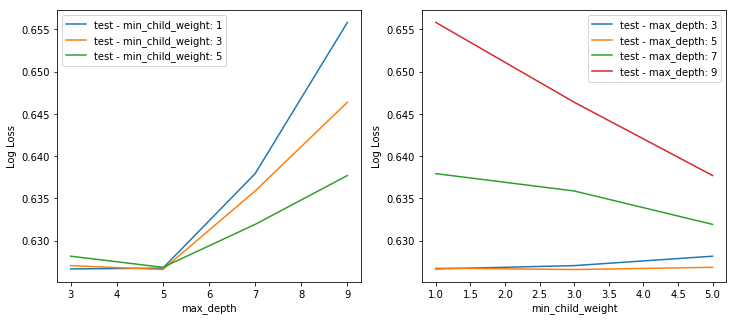

In [24]:
# 结果汇总

print("Best score is %f by using parameters of %s" % (gsearch2_1.best_score_, gsearch2_1.best_params_))

test_means = gsearch2_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch2_1.cv_results_[ 'std_test_score' ]
train_means = gsearch2_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch2_1.cv_results_[ 'std_train_score' ]
pd.DataFrame(gsearch2_1.cv_results_).to_csv('maxdepth_minchildweights_1.csv')

# 数据转化为矩阵，行对应于max_depth，列对应于min_child_weight
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

#  画图: max_depth与Log Loss的关系
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
for i, value in enumerate(min_child_weight):
#    plt.plot(max_depth, -train_scores[:,i], label= 'train - min_child_weight: '   + str(value))
    plt.plot(max_depth, -test_scores[:,i], label= 'test - min_child_weight: '   + str(value))
plt.legend()
plt.xlabel('max_depth')                                                                                                      
plt.ylabel('Log Loss')

#  画图: min_child_weight与Log Loss的关系
plt.subplot(122)
for i, value in enumerate(max_depth):
#    plt.plot(min_child_weight, -train_scores[i], label= 'train - max_depth: '   + str(value))
    plt.plot(min_child_weight, -test_scores[i], label= 'test - max_depth: '   + str(value))   
plt.legend()
plt.xlabel( 'min_child_weight' )                                                                                                      
plt.ylabel( 'Log Loss' )


小结：    
1) 对树参数max_depth 和 min_child_weight进行优化，在max_depth=5和min_child_weight=3的情况下，得到的最小交叉验证测试误差为：0.6266。

----------------------------------------------------------------------------------
# 5.  调整max_depth和min_child_weight之后再次调整n_estimators

In [25]:
# 基于上面的优化参数max_depth和min_child_weight，再次优化n_estimators 

def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        cvresult.to_csv('2_nestimators.csv', index_label = 'n_estimators')
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
         
           
    alg.fit(X_train, y_train, eval_metric='mlogloss')    
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)
    
    print('best n_estimators :',n_estimators)
    print('min logloss of train :',logloss)


In [26]:
# 设置xgb的参数，n_estimators为第一轮参数调整得到的最优值 

xgb2_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=122,   
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb2_3, X_train, y_train, cv_folds = kfold)


best n_estimators : 122
min logloss of train : 0.49577539351540617


最小的test-mlogloss-mean : 0.6272159999999999
最小的train-mlogloss-mean : 0.4681566666666667


Text(0,0.5,'Log Loss')

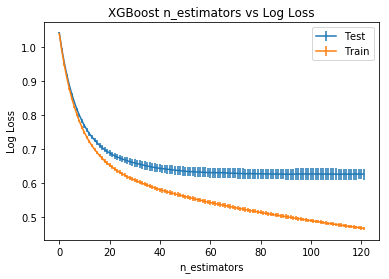

In [27]:
# 画图 n_estimators与Log Loss的关系

cvresult = pd.read_csv('2_nestimators.csv')  

print('最小的test-mlogloss-mean :',cvresult['test-mlogloss-mean'].values[-1])  
print('最小的train-mlogloss-mean :',cvresult['train-mlogloss-mean'].values[-1])

test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])

plt.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
plt.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
plt.legend()
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel( 'n_estimators' )
plt.ylabel( 'Log Loss' )

小结：   
1) 用优化的树参数max_depth=5和min_child_weight=3再次对训练集优化n_estimators，得到的最佳参数n_estimators=122(与第一次一样)。   
2) 最小交叉验证测试误差：0.6272，训练误差: 0.4682。 

------------------------------------------------------------------------------------------
# 6.  调整树的参数：subsample 和 colsample_bytree

In [28]:
# 设置subsample和colsample的范围

subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test3_1 = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test3_1

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [29]:
# 设置xgb的参数，n_estimators,max_depth,min_child_weight为前两步参数调整得到的最优值 

xgb3_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=122,   
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

gsearch3_1 = GridSearchCV(xgb3_1, param_grid = param_test3_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch3_1.fit(X_train , y_train)

gsearch3_1.grid_scores_, gsearch3_1.best_params_,     gsearch3_1.best_score_

([mean: -0.62397, std: 0.00368, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.62197, std: 0.00698, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.61779, std: 0.00540, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.61776, std: 0.00370, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.61809, std: 0.00574, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.61609, std: 0.00386, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.62503, std: 0.00478, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.62102, std: 0.00569, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.61890, std: 0.00505, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.61769, std: 0.00731, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.61757, std: 0.00498, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.61692, std: 0.00551, params: {'colsample_bytree': 0.7,

Best score is -0.616090 by using parameters of {'colsample_bytree': 0.6, 'subsample': 0.8}


Text(0,0.5,'Log Loss')

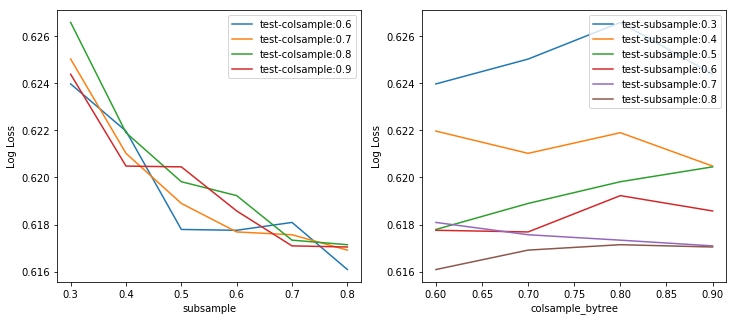

In [32]:
# 结果汇总

print("Best score is %f by using parameters of %s" % (gsearch3_1.best_score_, gsearch3_1.best_params_))

test_means = gsearch3_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch3_1.cv_results_[ 'std_test_score' ]
train_means = gsearch3_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch3_1.cv_results_[ 'std_train_score' ]
pd.DataFrame(gsearch3_1.cv_results_).to_csv('subsample_colsample_1.csv')

# 数据转化为矩阵，行对应于colsample_bytree，列对应于subsample
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

#  画图: subsample与Log Loss的关系的关系
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
for i, value in enumerate(colsample_bytree):
#    plt.plot(subsample, -train_scores[i], label= 'train-colsample:'   + str(value))
    plt.plot(subsample, -test_scores[i], label= 'test-colsample:'   + str(value))    
plt.legend()
plt.xlabel('subsample')                                                                                                      
plt.ylabel('Log Loss')

#  画图: colsample_bytree与Log Loss的关系
plt.subplot(122)
for i, value in enumerate(subsample):
#    plt.plot(colsample_bytree, -train_scores[:,i], label= 'train-subsample:'   + str(value))
    plt.plot(colsample_bytree, -test_scores[:,i], label= 'test-subsample:'   + str(value))    
plt.legend()
plt.xlabel('colsample_bytree')                                                                                                      
plt.ylabel('Log Loss')


小结：   
1) 对行列采样参数subsample 和colsample_bytree进行优化，在subsample=0.8和colsample_bytree=0.6的情况下，得到的最小交叉验证测试误差为：0.6161。

----------------------------------------------------------------------------------------
# 7.  调整正则化参数：reg_alpha 和reg_lambda

In [33]:
# 设置正则参数范围

reg_alpha = [0.1, 1, 1.5, 2]        # default = 0 
reg_lambda = [0.1, 0.5, 1, 2]      # default = 1 

param_test5_1 = dict(reg_alpha=reg_alpha, reg_lambda=reg_lambda)
param_test5_1

{'reg_alpha': [0.1, 1, 1.5, 2], 'reg_lambda': [0.1, 0.5, 1, 2]}

In [34]:
# 设置xgb的参数，n_estimators,max_depth,min_child_weight,subsample,colsample_bytree为前三步参数调整得到的最优值 

xgb5_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=122,   
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.6,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)

warnings.filterwarnings('ignore')  # 忽略错误信息

gsearch5_1 = GridSearchCV(xgb5_1, param_grid = param_test5_1, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch5_1.fit(X_train , y_train)

gsearch5_1.grid_scores_, gsearch5_1.best_params_,     gsearch5_1.best_score_

([mean: -0.61581, std: 0.00291, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1},
  mean: -0.61614, std: 0.00442, params: {'reg_alpha': 0.1, 'reg_lambda': 0.5},
  mean: -0.61507, std: 0.00392, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: -0.61488, std: 0.00370, params: {'reg_alpha': 0.1, 'reg_lambda': 2},
  mean: -0.61559, std: 0.00442, params: {'reg_alpha': 1, 'reg_lambda': 0.1},
  mean: -0.61633, std: 0.00374, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.61676, std: 0.00398, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -0.61650, std: 0.00367, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.61632, std: 0.00454, params: {'reg_alpha': 1.5, 'reg_lambda': 0.1},
  mean: -0.61678, std: 0.00444, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.61770, std: 0.00446, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.61591, std: 0.00477, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.61633, std: 0.00516, params: {'reg_alpha': 2, 'reg_lambda': 0

Best score is -0.614880 by using parameters of {'reg_alpha': 0.1, 'reg_lambda': 2}


Text(0,0.5,'-Log Loss')

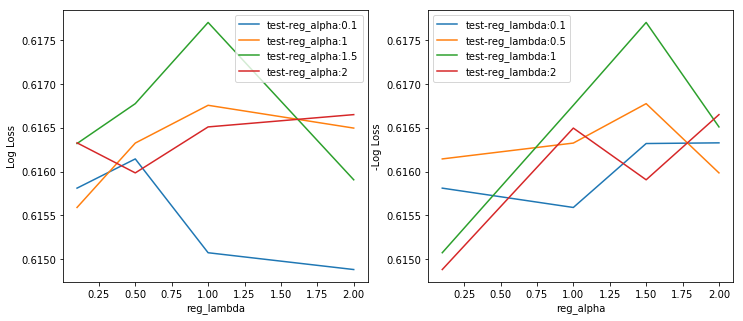

In [36]:
# 结果汇总

print("Best score is %f by using parameters of %s" % (gsearch5_1.best_score_, gsearch5_1.best_params_))

test_means = gsearch5_1.cv_results_[ 'mean_test_score' ]
test_stds = gsearch5_1.cv_results_[ 'std_test_score' ]
train_means = gsearch5_1.cv_results_[ 'mean_train_score' ]
train_stds = gsearch5_1.cv_results_[ 'std_train_score' ]
pd.DataFrame(gsearch5_1.cv_results_).to_csv('regalpha_reglambda_1.csv')

# 数据转化为矩阵，行对应于reg_alpha，列对应于reg_lambda
test_scores = np.array(test_means).reshape(len(reg_alpha), len(reg_lambda))
train_scores = np.array(train_means).reshape(len(reg_alpha), len(reg_lambda))

#  画图: reg_lambda与Log Loss的关系的关系
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
for i, value in enumerate(reg_alpha):
#    plt.plot(reg_lambda, -train_scores[i], label= 'train-reg_alpha:'   + str(value))
    plt.plot(reg_lambda, -test_scores[i], label= 'test-reg_alpha:'   + str(value))    
plt.legend()
plt.xlabel('reg_lambda')                                                                                                      
plt.ylabel('Log Loss')

#  画图: reg_alpha与Log Loss的关系
plt.subplot(122)
for i, value in enumerate(reg_lambda):
#    plt.plot(reg_alpha, -train_scores[:,i], label= 'train-reg_lambda:'   + str(value))
    plt.plot(reg_alpha, -test_scores[:,i], label= 'test-reg_lambda:'   + str(value))       
plt.legend()
plt.xlabel( 'reg_alpha' )                                                                                                      
plt.ylabel( '-Log Loss' )


小结：  
1) 对正则参数reg_alpha 和reg_lambda进行优化，在reg_alpha=0.1和reg_lambda=2的情况下，得到的最小交叉验证测试误差为：0.6149。

-------------------------------------------------------------------------------------------
# 结论： 

1) 用默认的xgboost对训练数据进行分类，用xgb.featureimportances查看特征重要性，得到在227个特征中，只有71个特征的重要性不为0。大部分的输入特征对分类结果不起作用。  
2) 用xgboost内嵌的cv、以及GridSearchCV等方法对训练数据采用交叉验证的方法进行优化分类，用训练集的全部输入特征，或是用训练集的重要性不为0的71个特征进行优化分类，两者得到的最小交叉验证测试误差相差不大。为了减少运行时间，用训练集的重要性不为0的71个特征进行优化分类。  
3) 用xgboost内嵌的cv、以及GridSearchCV等方法对训练数据采用交叉验证的方法进行优化分类，得到的最优参数为：n_estimators=122，max_depth=5， min_child_weight=3，subsample=0.8，colsample_bytree=0.6，reg_alpha=0.1，reg_lambda=2；在最优参数下最小交叉验证测试误差为：0.6149。